<a href="https://colab.research.google.com/github/Pterix753/mosconsumption/blob/main/Moscconsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
from datetime import datetime, time
from google.colab import data_table
data_table.enable_dataframe_formatter()
gen = pd.read_csv(r"/content/drive/My Drive/collab jupyter/consmodif200.csv",  encoding='cp1251', sep =';', converters={'Time': lambda y: str(y)})
#gen.dropna()     # в строке readcsv добавлена лямбда функция для каждого элемента столбца time читать как строку, НЕ ТЕРЯТЬ НУЛИ -01:11 например
gen.index=pd.to_datetime(gen["Time"],format='%d.%m.%Y %H:%M')
gen.asfreq('H')
gen

,temp,Cons,Hourinweek,Time
Time,,,,
2018-09-30 21:39:00,9,12886,166,30.09.2018 21:39
2018-09-30 22:39:00,9,12277,167,30.09.2018 22:39
2018-09-30 23:39:00,9,11360,168,30.09.2018 23:39
2018-10-01 00:39:00,8,10404,1,01.10.2018 0:39
2018-10-01 01:39:00,8,9735,2,01.10.2018 1:39
...,...,...,...,...
2021-12-15 10:39:00,-2,17227,59,15.12.2021 10:39
2021-12-15 11:39:00,-2,17328,60,15.12.2021 11:39
2021-12-15 12:39:00,-2,17135,61,15.12.2021 12:39


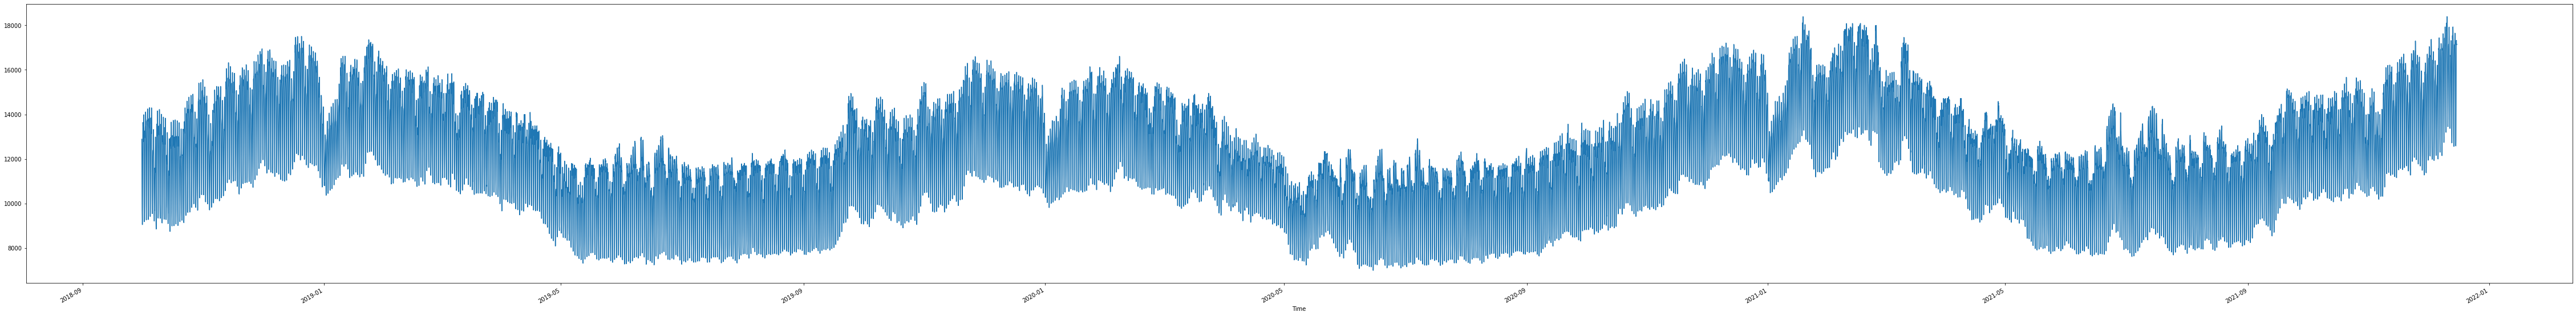

In [ ]:
gen['Cons'].plot(figsize=(80,10))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


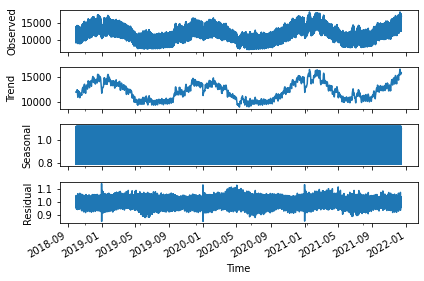

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(gen['Cons'], model='mul')  # model='mul' also works
result.plot();
# видно, что плохо работает с большим количеством сезонностей -суточная недельная годовая

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4a4f3e6510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4a4f3e6510>)

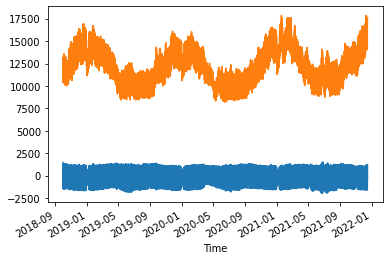

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter # Hodrick-Prescott filter
# Tuple unpacking здесь нуэно подумиать над величиной  лямбды
gdp_cycle, gdp_trend = hpfilter(gen['Cons'], lamb=129.6)
gdp_cycle.plot() ,  gdp_trend.plot()

In [ ]:
gen.index.freq = "H" # выбираем периодичность, условные обозначения можно найти в пандас 
gen.index

DatetimeIndex(['2018-09-30 21:39:00', '2018-09-30 22:39:00',
               '2018-09-30 23:39:00', '2018-10-01 00:39:00',
               '2018-10-01 01:39:00', '2018-10-01 02:39:00',
               '2018-10-01 03:39:00', '2018-10-01 04:39:00',
               '2018-10-01 05:39:00', '2018-10-01 06:39:00',
               ...
               '2021-12-15 05:39:00', '2021-12-15 06:39:00',
               '2021-12-15 07:39:00', '2021-12-15 08:39:00',
               '2021-12-15 09:39:00', '2021-12-15 10:39:00',
               '2021-12-15 11:39:00', '2021-12-15 12:39:00',
               '2021-12-15 13:39:00', '2021-12-15 14:39:00'],
              dtype='datetime64[ns]', name='Time', length=28122, freq='H')

For the smoothing factor α one must have 0<α≤1, and while it is possible to pass alpha directly, it’s often easier to think about either the span, center of mass (com) or half-life of an EW moment:

Span corresponds to what is commonly called an “N-day EW moving average”.
Center of mass has a more physical interpretation and can be thought of in terms of span:  c=(s−1)/2 
Half-life is the period of time for the exponential weight to reduce to one half.
Alpha specifies the smoothing factor directly.
We have to pass precisely one of the above into the .ewm() function. For our data we'll use span=12.

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
span=24
alpha = 2/(span+1)
gen['EWMA24']=gen['Cons'].ewm(alpha=alpha, adjust=False).mean()
gen['SES24']=SimpleExpSmoothing(gen['Cons']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
gen['DESmul24'] = ExponentialSmoothing(gen['Cons'], trend='mul').fit().fittedvalues.shift(-1)
gen['TESadd24'] = ExponentialSmoothing(gen['Cons'],trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues
gen['TESmul24'] = ExponentialSmoothing(gen['Cons'],trend='add',seasonal='mul',seasonal_periods=24).fit().fittedvalues
gen.head()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 193, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 169, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 5799, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-pa

,temp,Cons,Hourinweek,Time,EWMA24,SES24,DESmul24,TESadd24,TESmul24
Time,,,,,,,,,
2018-09-30 21:39:00,9,12886,166,30.09.2018 21:39,12886.000000,12886.000000,12885.999993,13126.102999,13443.632091
2018-09-30 22:39:00,9,12277,167,30.09.2018 22:39,12837.280000,12837.280000,11696.781701,12279.541960,12385.460096
2018-09-30 23:39:00,9,11360,168,30.09.2018 23:39,12719.097600,12719.097600,10511.493036,11245.662273,11354.167970
2018-10-01 00:39:00,8,10404,1,01.10.2018 0:39,12533.889792,12533.889792,9528.452113,10370.816850,10424.376961
2018-10-01 01:39:00,8,9735,2,01.10.2018 1:39,12309.978609,12309.978609,9109.018166,9738.318354,9745.686522


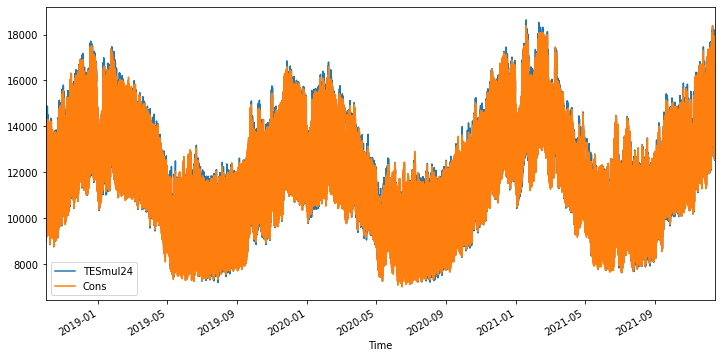

In [ ]:
gen[['TESmul24', 'Cons']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [ ]:
gen.tail() # возвращает последние

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 193, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 169, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 5799, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 4414, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert Time, already exists


,temp,Cons,Hourinweek,Time,EWMA24,SES24,DESmul24,TESadd24,TESmul24
Time,,,,,,,,,
2021-12-15 10:39:00,-2,17227,59,15.12.2021 10:39,15261.774481,15261.774481,17756.807814,17291.392895,17410.283516
2021-12-15 11:39:00,-2,17328,60,15.12.2021 11:39,15427.072522,15427.072522,17429.592152,17384.259314,17517.143317
2021-12-15 12:39:00,-2,17135,61,15.12.2021 12:39,15563.706720,15563.706720,16944.149642,17237.040518,17362.782058
2021-12-15 13:39:00,-2,17156,62,15.12.2021 13:39,15691.090183,15691.090183,17177.025737,17085.913081,17193.855700
2021-12-15 14:39:00,-1,17130,63,15.12.2021 14:39,15806.202968,NaN,NaN,17116.238048,17192.529018


In [ ]:
gen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28122 entries, 2018-09-30 21:39:00 to 2021-12-15 14:39:00
Freq: H
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        28122 non-null  int64  
 1   Cons        28122 non-null  int64  
 2   Hourinweek  28122 non-null  int64  
 3   Time        28122 non-null  object 
 4   EWMA24      28122 non-null  float64
 5   SES24       28121 non-null  float64
 6   DESmul24    28121 non-null  float64
 7   TESadd24    28122 non-null  float64
 8   TESmul24    28122 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 2.1+ MB


In [ ]:

train_data=gen.iloc[:int(gen['Cons'].size*0.8)] # берем от первого до 0,8 от размера выборки gencons soups
test_data=gen.iloc[(int(gen['Cons'].size*0.8)-1):] # берем от 0,8*size элемента для теста, не забыть вычесть 1, чтобы индексы не совпадали

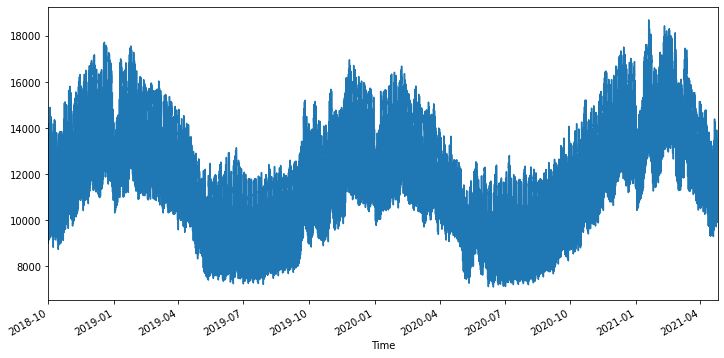

In [ ]:
fitted_model = ExponentialSmoothing(train_data['Cons'], trend='add', seasonal='mul', seasonal_periods=24).fit()
fitted_model.fittedvalues.plot(figsize=(12,6)).autoscale(axis='x',tight=True)

In [ ]:
test_predictions = fitted_model.forecast(168).rename('HW Forecast')


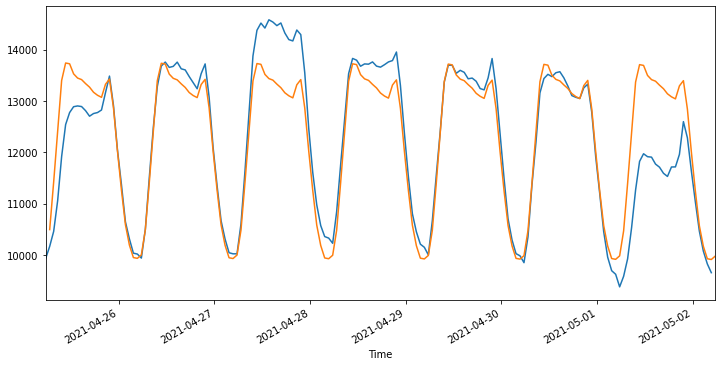

In [ ]:
test_data['Cons'].iloc[:168].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
test_predictions.plot(figsize=(12,6)).autoscale(axis='x',tight=True)
# ВИДНО, что учитывается только одна сезонность -суточная. Недельная и годовая нет.

In [ ]:
# METRICS
from sklearn.metrics import mean_squared_error,mean_absolute_error
mean_absolute_error(test_data['Cons'].iloc[:168],test_predictions)

673.7708372271421

In [ ]:
mean_squared_error(test_data['Cons'].iloc[:168],test_predictions)

751479.7741575827

In [ ]:
np.sqrt(mean_squared_error(test_data['Cons'].iloc[:168],test_predictions))

866.8793307938439

In [ ]:
test_data.describe()

,temp,Cons,Hourinweek,EWMA24,SES24,DESmul24,TESadd24,TESmul24
count,5626.000000,5626.000000,5626.000000,5626.000000,5625.000000,5625.000000,5626.000000,5626.000000
mean,12.271596,12026.983825,84.163704,12019.058313,12018.385043,12050.511351,12026.582756,12026.642150
std,9.591839,2166.309160,48.696594,1563.199906,1562.522884,2279.671536,2159.048353,2168.861678
min,-100.000000,7619.000000,1.000000,9329.302098,9329.302098,7288.998876,7632.059871,7622.093468
25%,6.000000,10618.000000,42.000000,10803.700676,10803.676242,10580.146704,10600.626227,10583.718156
50%,12.000000,12037.000000,84.000000,11663.613459,11663.553677,12073.809883,12040.804568,12031.503641
75%,20.000000,13432.750000,126.000000,12979.601111,12979.389621,13492.596308,13412.564351,13406.946361
max,34.000000,18394.000000,168.000000,17053.695503,17053.695503,18965.203812,18320.570097,18353.540418


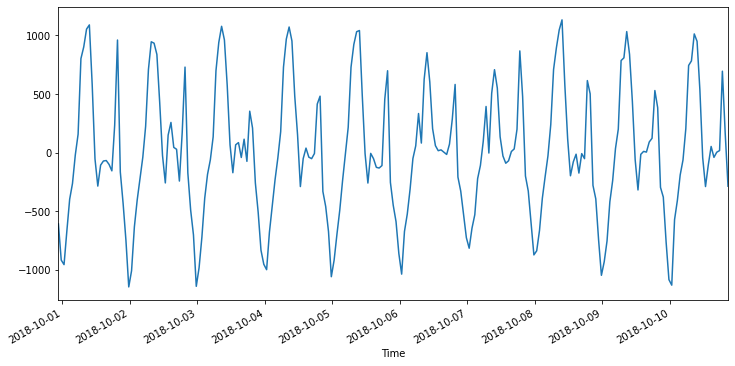

In [ ]:
gen['ConsSOUPSdf1'] = gen['Cons'] - gen['Cons'].shift(1)
gen['ConsSOUPSdf1'].iloc[:240].plot(figsize=(12,6)).autoscale(axis='x',tight=True);# первые разности или первая производная 

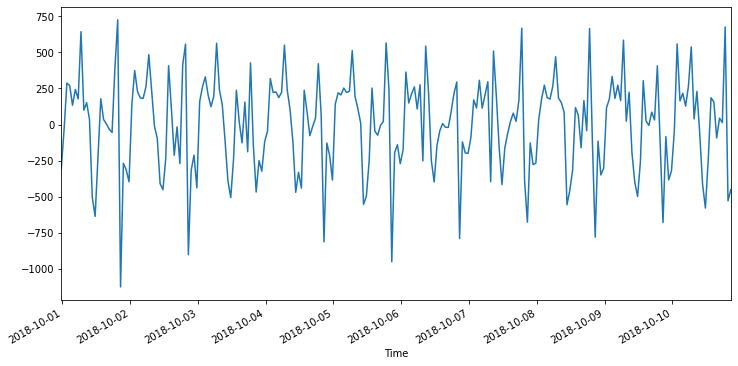

In [ ]:
from statsmodels.tsa.statespace.tools import diff
gen['ConsSOUPSdf11']=diff(gen['Cons'], k_diff=2)# вторые разности или вторая производная ДРУГОЙ СПОСОБ
gen['ConsSOUPSdf11'].iloc[:240].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [ ]:
# Import the models we'll be using in this section ACF PACF
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import warnings
warnings.filterwarnings("ignore")
 # For instance, the unbiased partial autocorrelation pacf_yw() performed below may raise a RuntimeWarning: invalid value encountered in sqrt.
arr3 = acf(gen['Cons'])# с какими из своих лагов коррелирует и как 
arr3 # конечно же по таблице видно, что лучшие корреляции с предыдущим часом и 23,24,25 часов до этого

array([1.        , 0.97558285, 0.91093655, 0.81866734, 0.71184282,
       0.60269621, 0.50138172, 0.41522602, 0.3486536 , 0.30292797,
       0.27572665, 0.26262079, 0.25824439, 0.26023865, 0.2709711 ,
       0.2957543 , 0.33892729, 0.40278768, 0.48611039, 0.58444529,
       0.69036284, 0.79370037, 0.88245144, 0.94410857, 0.96664532,
       0.9425405 , 0.8793523 , 0.78911649, 0.68439149, 0.57719679,
       0.47771378, 0.39326926, 0.32819088, 0.28354715, 0.25695577,
       0.24405887, 0.23968252, 0.24158243, 0.25204171, 0.27620012,
       0.31827228])

### Autocovariance Example:

> Блок с отступами

J здесь это ковариация (мат.ожид. произведен разностей величины и ее мат.ожид. М((x-MX)(y-My))

Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [ ]:
arr4 = pacf_yw(gen['Cons'],nlags=4,method='mle')
arr4

array([ 1.        ,  0.97558285, -0.84632985,  0.25644695,  0.085175  ])

In [ ]:
arr6 = pacf_ols(gen['Cons'],nlags=4)
arr6

array([ 1.        ,  0.97574549, -0.84927711,  0.2708397 ,  0.08083366])

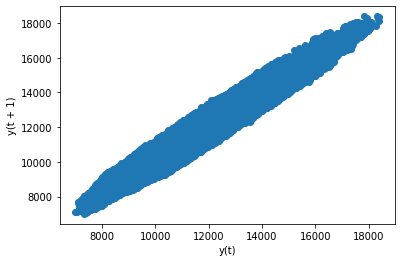

In [ ]:
from pandas.plotting import lag_plot

lag_plot(gen['Cons']);

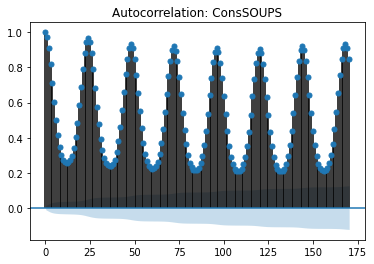

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# Now let's plot the autocorrelation at different lags/ 24 48 лаги высокая автокорреляция
# синее-95%дов.инт. явно выраженная сезонность 
title = 'Autocorrelation: ConsSOUPS'
lags = 170
plot_acf(gen['Cons'],title=title,lags=lags);

In [ ]:
from statsmodels.tsa.ar_model import AR,ARResults
model = AR(train_data['Cons'])  #авторегресс модель

In [ ]:
 AR1fit=model.fit(ic='t-stat')

In [ ]:
AR1fit.k_ar


43

In [ ]:
AR1fit.params

const       22.527859
L1.Cons      1.553020
L2.Cons     -0.526881
L3.Cons     -0.191020
L4.Cons      0.078744
L5.Cons      0.093683
L6.Cons      0.001950
L7.Cons     -0.049211
L8.Cons     -0.070635
L9.Cons      0.045598
L10.Cons     0.038150
L11.Cons     0.039285
L12.Cons    -0.047824
L13.Cons    -0.036827
L14.Cons     0.002017
L15.Cons     0.039650
L16.Cons    -0.031010
L17.Cons     0.013066
L18.Cons     0.021927
L19.Cons    -0.007619
L20.Cons    -0.001461
L21.Cons     0.007130
L22.Cons    -0.043175
L23.Cons     0.075392
L24.Cons     0.787956
L25.Cons    -1.266939
L26.Cons     0.379323
L27.Cons     0.221586
L28.Cons    -0.087354
L29.Cons    -0.094346
L30.Cons    -0.000259
L31.Cons     0.046597
L32.Cons     0.055584
L33.Cons    -0.023934
L34.Cons    -0.050321
L35.Cons    -0.007618
L36.Cons     0.025301
L37.Cons     0.039529
L38.Cons    -0.029714
L39.Cons    -0.000070
L40.Cons    -0.002666
L41.Cons     0.006374
L42.Cons    -0.033787
L43.Cons     0.028968
dtype: float64

In [ ]:
start=len(train_data['Cons'])
start

22497

In [ ]:
end=len(train_data['Cons'])+len(test_data['Cons'])-1
end

28122

In [ ]:
ARpredict = AR1fit.predict(start=start,end=end)

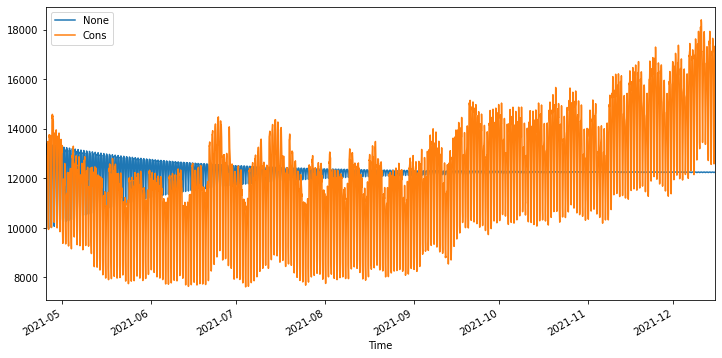

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
error=MSE(test_data['Cons'], ARpredict)
error
ARpredict.plot(legend = 'true',figsize=(12,6)).autoscale(axis='x',tight=True);
test_data['Cons'].plot(legend = 'true',figsize=(12,6)).autoscale(axis='x',tight=True);

In [ ]:
train_data.groupby('Hourinweek')
train_data

,temp,Cons,Hourinweek,Time,EWMA24,SES24,DESmul24,TESadd24,TESmul24
Time,,,,,,,,,
2018-09-30 21:39:00,9,12886,166,30.09.2018 21:39,12886.000000,12886.000000,12885.999993,13126.102999,13443.632091
2018-09-30 22:39:00,9,12277,167,30.09.2018 22:39,12837.280000,12837.280000,11696.781701,12279.541960,12385.460096
2018-09-30 23:39:00,9,11360,168,30.09.2018 23:39,12719.097600,12719.097600,10511.493036,11245.662273,11354.167970
2018-10-01 00:39:00,8,10404,1,01.10.2018 0:39,12533.889792,12533.889792,9528.452113,10370.816850,10424.376961
2018-10-01 01:39:00,8,9735,2,01.10.2018 1:39,12309.978609,12309.978609,9109.018166,9738.318354,9745.686522
...,...,...,...,...,...,...,...,...,...
2021-04-25 01:39:00,3,10906,146,25.04.2021 1:39,12398.706468,12398.706468,10337.288024,10803.795251,10797.686097
2021-04-25 02:39:00,3,10484,147,25.04.2021 2:39,12245.529950,12245.529950,10078.328993,10472.188450,10504.065628
2021-04-25 03:39:00,3,10230,148,25.04.2021 3:39,12084.287554,12084.287554,9982.153758,10169.575063,10235.601408


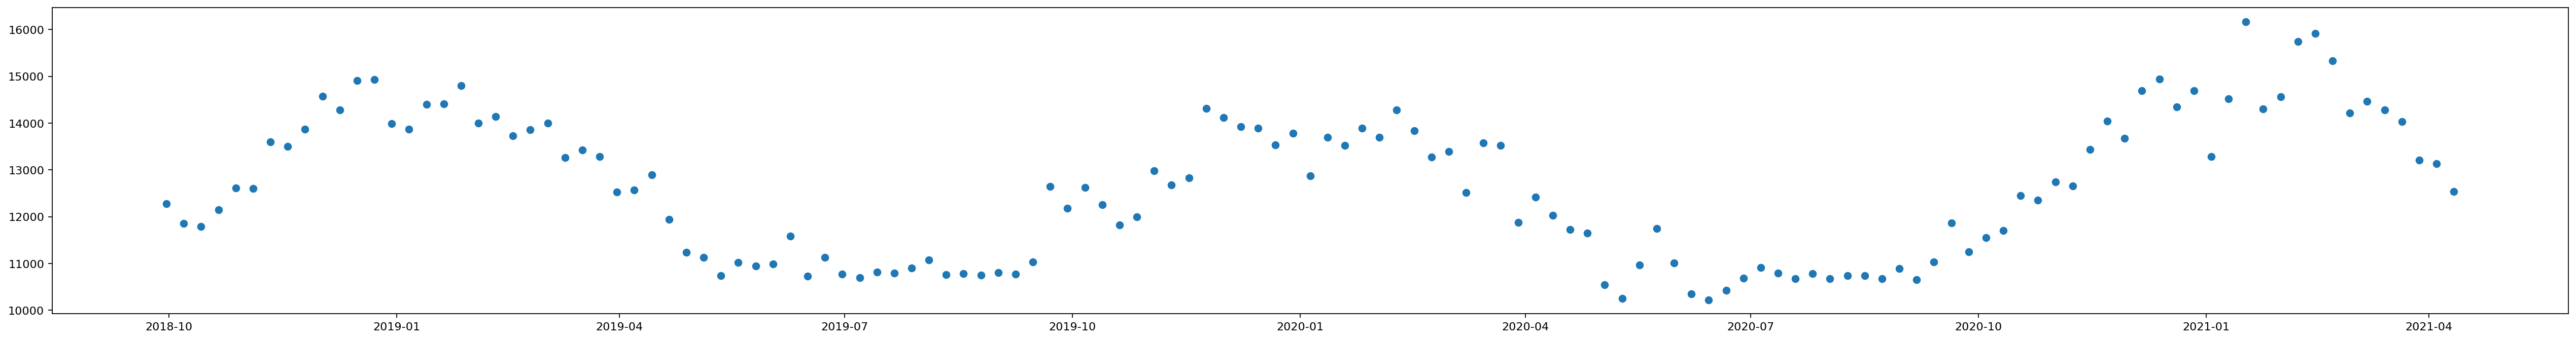

In [ ]:
import time
dayconsVal=pd.DataFrame()
dayconsDat=pd.DataFrame()
dayconstemp=pd.DataFrame()
#train_data['Date']=datetime.date(train_data['Time'].day, train_data['Time'].month, train_data['Time'].year)
#train_data['Date']=(time.strftime(str(train_data["Time"]),format='%d.%m.%Y %H:%M').tm_mon, time.strptime(str(train_data["Time"]),format='%d.%m.%Y %H:%M').tm_wday,time.strptime(str(train_data["Time"]),format='%d.%m.%Y %H:%M').tm_hour)
#train_data['Date']=pd.to_datetime(train_data["Time"],format='%d.%m.%Y %H:%M')
#train_data['Date']=datetime.date(train_data['Date'])
train_data['Date']=train_data["Time"].apply(lambda st: st.partition(' ')[0])
train_data['Date']=pd.to_datetime(train_data["Date"],format='%d.%m.%Y')
for x in range(0,24*7,1):
    for y in range(0,int(22497/(24*7)),1):
      dayconsVal.loc[y,x] = train_data['Cons'][x+24*7*y]
      dayconsDat.loc[y,x] = train_data['Date'][x+24*7*y]
      dayconstemp.loc[y,x]=train_data['temp'][x+24*7*y]
mpl.pyplot.figure(figsize=(40,5), dpi=160)
mpl.pyplot.scatter(dayconsDat[1],dayconsVal[1])
mpl.pyplot.savefig('pic.png')

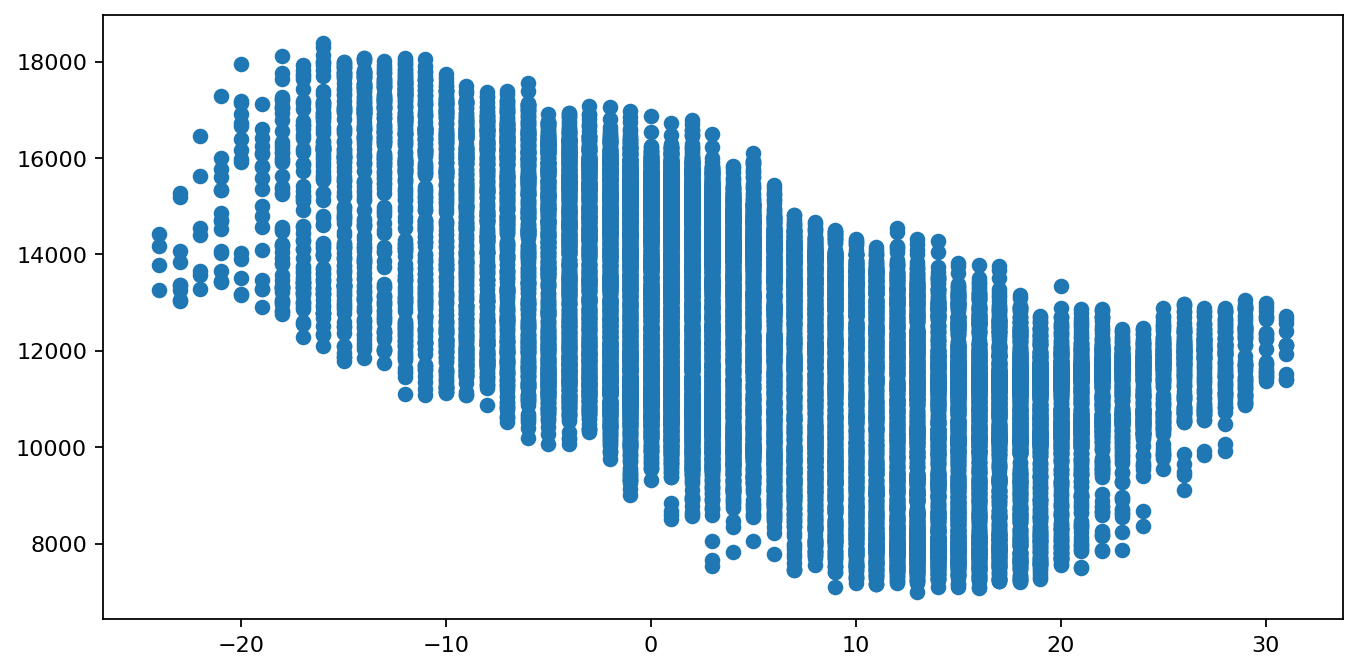

In [ ]:
mpl.pyplot.figure(figsize=(10,5), dpi=160)
mpl.pyplot.scatter(train_data['temp'],train_data['Cons'])
mpl.pyplot.savefig('pic.png')

Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the augmented Dickey-Fuller Test. In this test the null hypothesis states that  ϕ=1  (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ( p<0.05 ) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is not stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [ ]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
dftest=adfuller(test_data['Cons'], autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])
dfout

ADF test statistic      -2.072339
p-value                  0.255782
# lags used             32.000000
# observations        5593.000000
dtype: float64

p-value is high, so we cannot reject null hypo and conclude that time serie is NON stationary. Let's make our own function fo test

In [ ]:
# функция для Дики Фуллер тест
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series,autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(test_data['Cons'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.072339
p-value                    0.255782
# lags used               32.000000
# observations          5593.000000
critical value (1%)       -3.431520
critical value (5%)       -2.862057
critical value (10%)      -2.567045
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.DataFrame()
from statsmodels.tsa.statespace.tools import diff
df['difcons']=diff(train_data['Cons'], k_diff=1)
adf_test(df['difcons'])# adf показывает, что на 1 производной ряд становится стационарным

Augmented Dickey-Fuller Test: 
ADF test statistic        -21.183042
p-value                     0.000000
# lags used                47.000000
# observations          22448.000000
critical value (1%)        -3.430641
critical value (5%)        -2.861669
critical value (10%)       -2.566839
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
